In [1]:
%load_ext autoreload
%autoreload 2


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.cluster import KMeans 
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering

In [3]:
np.random.seed(seed = 0)

In [52]:
#Enrty point functions
#1.
def generate_data_points(N = 10000, D = 2, f_gen_name = 'uniform_dist', **kwargs_fun):
    """
    N:(int) Number of points to genrate
    D:(int) Number of dimensions 
    f_gen_name:(string) Name of distribution to generate points
    kwargs_fun: dictionary 
    
    """

    
    return eval(f_gen_name+'(N, D, **kwargs_fun)')

#2.
def assign_class(data, f_class_name = 'circle_class', **kwargs_fun):
    """
    data: Dataframe with features
    f_class_name: the name of the function to be applied to 
    generate the clusters
    kwargs_fun: keyword arguments to go into the generation function
    
    returns: DataFrame same as data but with an extra column C
    containing the class each point belongs
    """
    
    return eval(f_class_name+'(data,**kwargs_fun)')

#3.
def assign_treatment(data, f_treat_name = 'uniform_treat', **kwargs_fun):
    """
    data: Dataframe with features and class C
    f_treat_name: the name of the function to be applied to 
    generate the treatment groups
    kwargs_fun: keyword arguments to go into the treatment generation function
    
    returns: DataFrame same as data but with an extra column T
    containing the treatemnt group each point belongs
    """
    
    return eval(f_treat_name+'(data,**kwargs_fun)')

#4.
def assign_outcome(data, f_outcome_name = 'outcome1', **kwargs_fun):
    """
    data: Dataframe with features, class C and treatment "Treatment"
    f_treat_name: the name of the function to be applied to 
    generate the treatment groups
    kwargs_fun: keyword arguments to go into the treatment generation function
    
    returns: DataFrame same as data but with an extra column T
    containing the treatemnt group each point belongs
    """
    
    return eval(f_outcome_name+'(data,**kwargs_fun)')

#5.
def assign_clustering(data, f_cluster_algo_name = 'box_clustering', **kwargs_fun):
    
    return eval(f_cluster_algo_name+('data, **kwargs_fun'))


###########  Distributions

def uniform_gen(N = 10000, D = 2, low = 0, high = 1):
    """
    N:(int) number of data points
    D:(int) number of dimensions
    low:(float) lowest range of generated points
    high:(float) highest range of generted points
    
    Generates a NxD matrix uniformly at random
    returns: DataFrame NxD with column names x_0, ..., x{D-1}
    """
    features = ['x'+str(i) for i in range(D)]
    
    X = np.random.uniform(low = low, high = high, size = (N,D))
    return pd.DataFrame(X, columns = features )


###########  Eligibility functions

def circle_class(data, centers = None, r_small = 0.2, r_big = 0.5):
    """
    
    data: Dataframe with features x_0,...,x_d
    center = (list) with the centers of the circle function
    r_small: (float) small radius
    r_big: (float) big radius
    assigns data into clusters according to circle function
    
    """
    center = np.array(centers)
    if data.shape[1] != len(centers):
        raise ValueError('Data Should be in the form NxD and centers in the form [c1,...,cD]')
        
    ans = np.sqrt(np.sum((data.values-centers)**2, axis = 1))
    cls =  ((ans >= r_small) & (ans <= r_big)).astype(int)
    data['C'] = cls
    return data


###########   Treatement Functions

def uniform_treat(data, choices = None, probabilities = None):
    """
    data:(pandas array) columns x1,...,xD, C
    choices: list with integers to sample from
    probabilities: probabilities to sample each integer from choices
    (need to sum to 1)
    Generates treatment assignment uniformly at random
    """
    N = len(data)
    ch = np.random.choice(choices, size=N, replace=True, p=probabilities)
    data['Treatment'] = ch
    return data


########### Outcome Functions

def outcome1(data,  treatment = 'Treatment', cls = 'C', stats = None):
    """
    Produces the outcome Y as a function of Treatement and Class C
    data:DataFrame, should contain columns C and Treatment
    column_selection: list of columns to use for outcome
    stats: 4x2 matrix containing the means and standard deviations
     for the 4 cases 
     Case 1: Treatment 0 C 0
     Case 2: Treatment 0 C 1
     Case 3: Treatemnt 1 C 0
     Case 4: Treatemnt 1 C 1
    
    returns a dataframe like data but with two extra columns Y and Ycf
    """
    
    
    def sample(group):
        t = group[treatment].iloc[0]
        c = group[cls].iloc[0]
        tdot = 1-t
        statsf = stats[int(t*2+c)]
        statscf = stats[int(tdot*2+c)]
        N = len(group)
        group['Y'] = np.random.normal(loc = statsf[0], scale=statsf[1], size = N)
        group['Ycf'] = np.random.normal(loc = statscf[0], scale=statscf[1], size = N)
        
        return group
    
    new_data = data.groupby(by = [cls, treatment]).apply(sample).reset_index(drop = True)
    
    return new_data
    

####### Clustering Algorithms

#Clustering the goal is to take the data and apply the clustering algorithm and nothing more

#1. box clustering
def box_clustering(data, clusters = 100,cluster_name ='Box-Cluster',
                   min_support=0, max_support=1, col_select = None):
    """
    data: pandas array with data to apply box clustering
    clusters:(number of boxes) clusters
    min_support:(float) the minimum value the box clustering is considering
    max_support:(float) the maximum value the box clustering is considering
    box_length(deprecated):(float) the length of each box
    col_select:[list of strings] names of features to consider for clustering
    
    returns the dataframe with the clustering applied
    """
    values = data[col_select].values
    boxes_per_dim = int(clusters**(1/values.shape[1]))
    box_length = (max_support-min_support)/boxes_per_dim
    grid_length = int((max_support-min_support)/box_length)
    coord_float = np.floor((values-min_support)/box_length).astype('int')
    pivot_array = np.array([grid_length**i for i in range(values.shape[1])])
    index_array = np.sum(coord_float*pivot_array, axis = 1).astype(int)
    
    #values_pd = pd.DataFrame(values, columns = x_names)
    data[cluster_name] = index_array
    
    return data, boxes_per_dim

#2. Kmeans
def kmeans_clustering(data, clusters=100,cluster_name = 'Kmeans-Cluster', col_select=None, **kwargs):
    """
    
    data: pandas array with data to apply box clustering
    clusters:(number of boxes) clusters
    
    """
    if len(col_select) == 1:
        values = data[col_select].values.reshape(-1,1)
    else:
        values = data[col_select].values
        
    kmeans = KMeans(n_clusters = clusters, **kwargs)
    kmeans = kmeans.fit(values)
    data[cluster_name] = kmeans.predict(values)
    
    return data, kmeans
    
#3. Spectral
def spectral_clustering(data, clusters=100, cluster_name = 'Spectral-Cluster', col_select=None, **kwargs):
    """
    
    data: pandas array with data to apply box clustering
    clusters:(number of boxes) clusters
    
    """
    if len(col_select) == 1:
        values = data[col_select].values.reshape(-1,1)
    else:
        values = data[col_select].values
        
    spec = SpectralClustering(n_clusters = clusters, **kwargs)
    spec = spec.fit(values)
    data[cluster_name] = spec.labels_
    
    return data, spec

#4. Agglomerative
def agglomerative_clustering(data, clusters=100, cluster_name = 'Agglomerative-Cluster', col_select=None, **kwargs):
    """
    
    data: pandas array with data to apply box clustering
    clusters:(number of boxes) clusters
    
    """
    if len(col_select) == 1:
        values = data[col_select].values.reshape(-1,1)
    else:
        values = data[col_select].values
        
    agglo = AgglomerativeClustering(n_clusters = clusters, **kwargs)
    agglo = agglo.fit(values)
    data[cluster_name] = agglo.labels_
    
    return data, agglo
    
    

###### Evaluations Homogeinity




##### Evaluations ATT

def computeATT_cluster_knownCF(data, treatment = "Treatment", cluster_name = None,
                               outcome = 'Y', counterfactual = 'Ycf', ITE_name = 'ITE', 
                               ATT_CLUST_name = 'ATT_CLUST'):
    """
    
    Computes the ATT for each cluster
    with a known Counter Factual Outcome
    counterfactual(string): column name of the counterfactual
    
    """
    filt = data[treatment] == 1
    data2 = data[filt].reset_index(drop = True)
    data2[ITE_name] =  data2[outcome]-data2[counterfactual]
    
    res = data2.groupby(cluster_name, sort = True).apply(lambda x: pd.Series([x[ITE_name].mean(), len(x)],
                                                     index = [ATT_CLUST_name, '#CLUST_POINTS'])).reset_index()
    
    return res
    
def computeITE_knownCF(data, treatment = "Treatment",
                               outcome = 'Y', counterfactual = 'Ycf'):
    
    filt = data[treatment] == 1
    data2 = data[filt].reset_index(drop = True)
    data2['ITE'] =  data2[outcome]-data2[counterfactual]
    
    return data2




## 1. Generate Data Points According to some Distribution

In [5]:
N, D = 100000, 2
kwargs_generate = {'N':N, 'D':D,'f_gen_name': 'uniform_gen','low':0, 'high': 1}
df = generate_data_points(**kwargs_generate)

## 2. Generate Classification of Points According to some Function

In [6]:
f_class_name = 'circle_class'
kwargs_class ={'centers': [0.5, 0.5], 'r_small': 0.2, 'r_big':0.4}

df2 = assign_class(df.copy(), f_class_name=f_class_name, **kwargs_class)

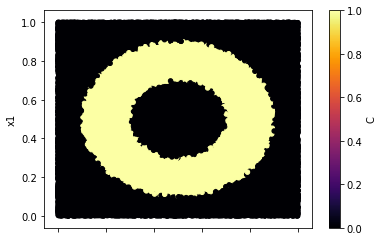

In [7]:
df2.plot.scatter(x='x0', y='x1', c='C', colormap='inferno')
plt.show()

## 3. Assign Treatment in Some Way

In [8]:
f_treat_name = 'uniform_treat'
kwargs_treat = {'choices':[0,1], 'probabilities':[0.5,0.5]}
df3 = assign_treatment(df2.copy(), f_treat_name = f_treat_name, **kwargs_treat)

## 4. Assign Outcome in Some Way

In [9]:
f_outcome_name = 'outcome1'
stats = np.array([[1, 0.3], [0, 0.3], [1, 0.3], [1, 0.3]])
kwargs_outcome = {'treatment':'Treatment', 'cls':'C', 'stats':stats}
df4 = assign_outcome(df3.copy(), f_outcome_name=f_outcome_name, **kwargs_outcome)

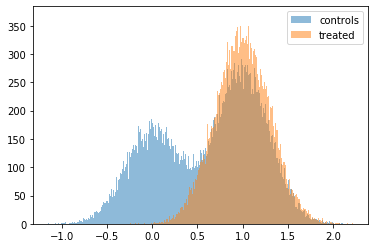

In [10]:
groups = df4.groupby('Treatment', sort = True)
fig, ax = plt.subplots()
for (i,group) in groups:
    ax.hist(group['Y'], bins=500, alpha = 0.5)
ax.legend(['controls', 'treated'])
fig.show()

In [11]:
gg = [ggi for ggi in groups]

In [12]:
gg[1][1].loc[gg[1][1].Treatment == 1].mean()

x0           0.500147
x1           0.502179
C            0.374082
Treatment    1.000000
Y            1.001146
Ycf          0.625979
dtype: float64

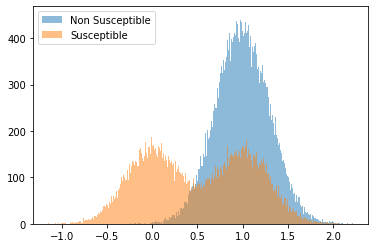

In [13]:
groups = df4.groupby('C', sort = True)
fig, ax = plt.subplots()
for (i,group) in groups:
    ax.hist(group['Y'], bins =500, alpha = 0.5)
ax.legend(['Non Susceptible', 'Susceptible'])
fig.show()

## 5. Apply a Clustering Algorithm(Optional)

In [14]:
%%time
col_select = ['x0', 'x1']

#box clustering
box_args = {'clusters' : 100, 'cluster_name':'Box-Cluster',
                   'min_support':0,'max_support':1, 'col_select':col_select}
df5,_ = box_clustering(df4.copy(), **box_args)

#kmeans
#kmeans_args = 
df6, kms = kmeans_clustering(df5.copy(), col_select = col_select)

CPU times: user 42min 5s, sys: 3.08 s, total: 42min 8s
Wall time: 56.8 s


In [15]:
from sklearn.model_selection import train_test_split
df6, df6ts = train_test_split(df6, test_size = 0.2, random_state = 0)



In [16]:
df6.head(3)

,x0,x1,C,Treatment,Y,Ycf,Box-Cluster,Kmeans-Cluster
10382,0.529956,0.811703,1,1,1.072547,-0.189421,85,62
73171,0.326706,0.637165,1,0,0.342524,1.250790,63,49
30938,0.317685,0.858681,0,1,0.566916,0.778082,83,78


## 6.0 Compute YCf estimate

In [17]:
from sklearn.ensemble import GradientBoostingRegressor


In [18]:
%%time
gbrTr = GradientBoostingRegressor()
gbrCon = GradientBoostingRegressor()

df6Tr, df6Con = df6[df6.Treatment == 1], df6[df6.Treatment == 0]
gbrTr = gbrTr.fit(df6Tr[col_select].values, df6Tr['Y'].values)
gbrCon = gbrCon.fit(df6Con[col_select].values, df6Con['Y'].values)


CPU times: user 6.07 s, sys: 961 µs, total: 6.07 s
Wall time: 6.07 s


### Evaluate Learners on Test set

In [19]:
YTr = gbrTr.predict(df6ts.loc[df6ts.Treatment == 1, col_select].values)
YCon = gbrCon.predict(df6ts.loc[df6ts.Treatment == 0, col_select].values)

In [20]:
from sklearn.metrics import mean_squared_error as mse

In [21]:
YTr_true = df6ts.loc[df6ts.Treatment == 1, 'Y'].values
YCon_true = df6ts.loc[df6ts.Treatment == 0, 'Y'].values

eTr = mse(YTr_true, YTr, squared = False)
eCon = mse(YCon_true, YCon, squared = False)

In [22]:
np.mean(YTr), np.mean(YTr_true), np.mean(YCon), np.mean(YCon_true)

(1.001582425506023, 0.9992988772659014, 0.6264747338176394, 0.6233282621587211)

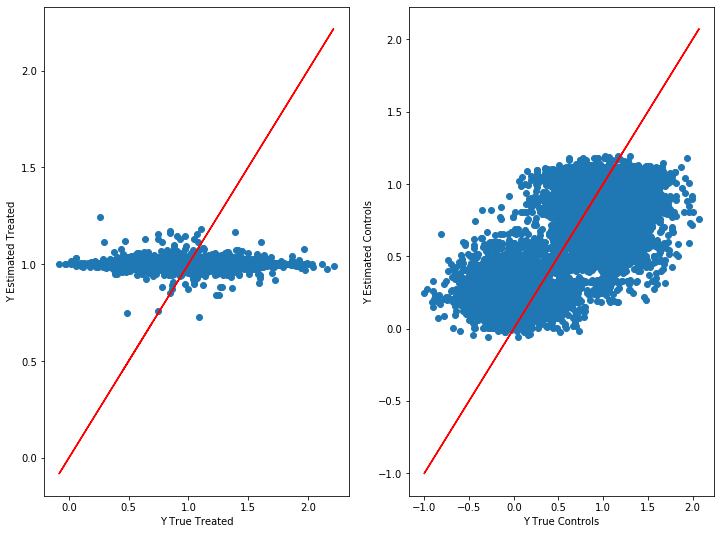

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = [12,9])
ax1.scatter(YTr_true, YTr)
ax2.scatter(YCon_true, YCon)

ax1.set_xlabel('Y True Treated')
ax2.set_xlabel('Y True Controls')
ax1.set_ylabel('Y Estimated Treated')
ax2.set_ylabel('Y Estimated Controls')
ax1.plot(YTr_true, YTr_true, 'r')
ax2.plot(YCon_true, YCon_true, 'r')
plt.show()

In [24]:
col = pd.MultiIndex.from_tuples([('GBTr', 'RMSE'), ('GBCon', 'RMSE')])
res = pd.DataFrame([[eTr, eCon]], columns = col )

In [25]:
res

,GBTr,GBCon
,RMSE,RMSE
0,0.300702,0.389048


In [26]:
df6['Ycf_est'] = 0

In [27]:
df6.loc[df6.Treatment == 1, 'Ycf_est'] = gbrCon.predict(df6.loc[df6.Treatment == 1, col_select])
df6.loc[df6.Treatment == 0, 'Ycf_est'] = gbrTr.predict(df6.loc[df6.Treatment == 0, col_select])

## 6. Compute ATT per Cluster(Ycf is needed)

In [66]:
%time
resKm = computeATT_cluster_knownCF(df6.copy(), cluster_name='Kmeans-Cluster', counterfactual = 'Ycf_est')
resbox = computeATT_cluster_knownCF(df6.copy(), cluster_name='Box-Cluster', counterfactual = 'Ycf_est')
resITE = computeITE_knownCF(df6.copy(), counterfactual = 'Ycf_est')

CPU times: user 20 µs, sys: 0 ns, total: 20 µs
Wall time: 40.5 µs


### With known CF

In [29]:
resKm2 = computeATT_cluster_knownCF(df6.copy(), cluster_name='Kmeans-Cluster', counterfactual = 'Ycf')
resbox2 = computeATT_cluster_knownCF(df6.copy(), cluster_name='Box-Cluster', counterfactual = 'Ycf')
resITE2 = computeITE_knownCF(df6.copy(), counterfactual = 'Ycf')

In [30]:
resKm.head()

,Kmeans-Cluster,ATT_CLUST,#CLUST_POINTS
0,0,0.486215,370.0
1,1,0.294941,371.0
2,2,0.594424,380.0
3,3,-0.015088,348.0
4,4,0.588767,444.0


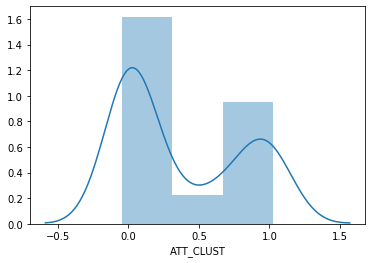

In [31]:
sns.distplot(resKm2['ATT_CLUST'])
plt.show()

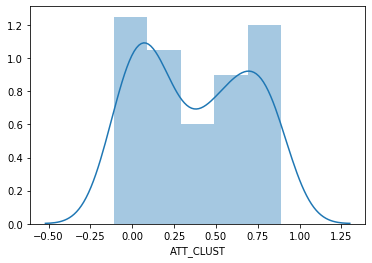

In [32]:
sns.distplot(resKm['ATT_CLUST'])
plt.show()

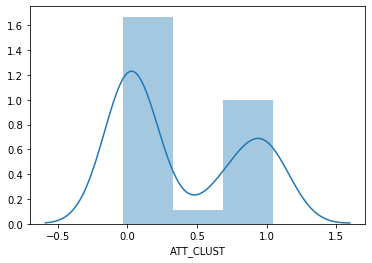

In [33]:
sns.distplot(resbox2['ATT_CLUST'])
plt.show()

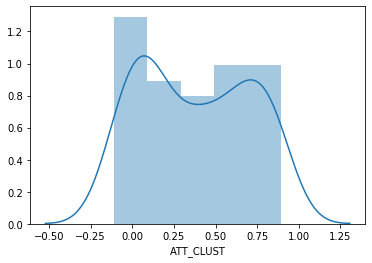

In [34]:
sns.distplot(resbox['ATT_CLUST'])
plt.show()

In [35]:
resbox.head()

,Box-Cluster,ATT_CLUST,#CLUST_POINTS
0,0,-0.102980,392.0
1,1,-0.110913,378.0
2,2,-0.016204,391.0
3,3,0.096509,416.0
4,4,0.158549,387.0


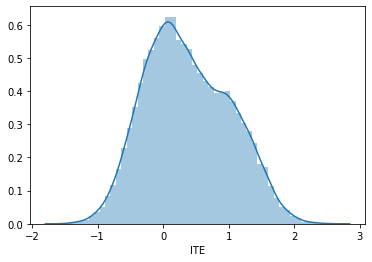

In [36]:
sns.distplot(resITE2['ITE'])
plt.show()

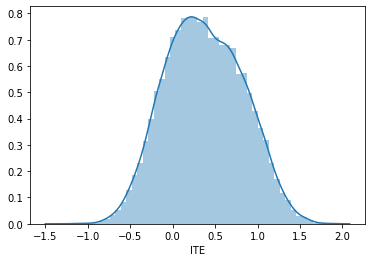

In [37]:
sns.distplot(resITE['ITE'])
plt.show()

## 7. Cluster ATTs(or ITEs if not a clustering algorithm)

In [38]:
resbox2,_ = kmeans_clustering(resbox.copy(), clusters=2,col_select = ['ATT_CLUST'],cluster_name = 'Box-2-Clust')
resKm2,_ = kmeans_clustering(resKm.copy(), clusters=2,col_select = ['ATT_CLUST'],cluster_name = 'Kmeans-2-Clust')
resITE2,_ = kmeans_clustering(resITE.copy(), clusters=2,col_select = ['ITE'],cluster_name = 'ITE-2-Clust')

In [39]:
resbox2.head()

,Box-Cluster,ATT_CLUST,#CLUST_POINTS,Box-2-Clust
0,0,-0.102980,392.0,1
1,1,-0.110913,378.0,1
2,2,-0.016204,391.0,1
3,3,0.096509,416.0,1
4,4,0.158549,387.0,1


In [40]:
resKm2.head()

,Kmeans-Cluster,ATT_CLUST,#CLUST_POINTS,Kmeans-2-Clust
0,0,0.486215,370.0,1
1,1,0.294941,371.0,0
2,2,0.594424,380.0,1
3,3,-0.015088,348.0,0
4,4,0.588767,444.0,1


In [41]:
resbox2.groupby('Box-2-Clust')['ATT_CLUST'].mean()

Box-2-Clust
0    0.701531
1    0.121004
Name: ATT_CLUST, dtype: float64

In [42]:
resKm2.groupby('Kmeans-2-Clust')['ATT_CLUST'].mean()

Kmeans-2-Clust
0    0.078014
1    0.662806
Name: ATT_CLUST, dtype: float64

In [43]:
resITE2.groupby('ITE-2-Clust')['ITE'].mean()

ITE-2-Clust
0    0.019625
1    0.774397
Name: ITE, dtype: float64

In [45]:
def homogeneity(data, group_name = 'box#', class_name='y'):

    return data.groupby(group_name).apply(lambda x: pd.Series(x[class_name].value_counts().max()/x[class_name].value_counts().sum(), index = ['homogeinity']))
    

### Homogeneity experiments

In [48]:
df6.head()

,x0,x1,C,Treatment,Y,Ycf,Box-Cluster,Kmeans-Cluster,Ycf_est
10382,0.529956,0.811703,1,1,1.072547,-0.189421,85,62,0.244603
73171,0.326706,0.637165,1,0,0.342524,1.250790,63,49,1.001715
30938,0.317685,0.858681,0,1,0.566916,0.778082,83,78,0.347903
99310,0.921027,0.405834,0,1,1.383377,1.164249,49,77,0.891113
58959,0.078926,0.660294,0,0,1.242055,1.230888,60,95,0.999817


In [67]:
lengths = [ 0.1, 0.2, 0.25, 0.5]
clusters = [int((1/l)**2) for l in lengths]

In [68]:
clusters

[100, 25, 16, 4]

In [69]:
graph_box = []
for cl in clusters:
    df6,_ = box_clustering(df6.copy(), clusters = cl, col_select= col_select)
    hom = homogeneity(df6, group_name='Box-Cluster', class_name='C').mean().iloc[0]
    graph_box.append([cl, hom])

In [70]:
graph_box

[[100, 0.9377257728554608],
 [25, 0.7684493047612553],
 [16, 0.6233007131112276],
 [4, 0.6232923615229727]]

In [71]:
%%time
graph_km = []
for cl in clusters:
    print(cl)
    df6,_= kmeans_clustering(df6.copy(), clusters = cl,col_select= col_select)
    hom = homogeneity(df6, group_name='Kmeans-Cluster', class_name='C').mean().iloc[0]
    graph_km.append([cl, hom])

100
25
16
4
CPU times: user 1h 31min 22s, sys: 8.95 s, total: 1h 31min 31s
Wall time: 5min 20s


%%time
graph_spec = []
for cl in clusters:
    print(cl)

    df6,_= spectral_clustering(df6.copy(), clusters = cl,col_select= col_select)
    hom = homogeneity(df6, group_name='Spectral-Cluster', class_name='C').mean().iloc[0]
    graph_spec.append([cl, hom])

In [76]:
%%time
graph_agglo = []
for cl in clusters:
    print(cl)

    df6,_= agglomerative_clustering(df6.copy(), clusters = cl,col_select= col_select)
    hom = homogeneity(df6, group_name='Agglomerative-Cluster', class_name='C').mean().iloc[0]
    graph_agglo.append([cl, hom])

100
25
16
4
CPU times: user 18min 1s, sys: 1min, total: 19min 2s
Wall time: 21min 33s


In [77]:

graphs = [graph_box, graph_km, graph_agglo]#,graph_spec, graph_agglo]
names = ['box', 'kmeans', 'agglomerative']#,'spectral', 'agglomerative']

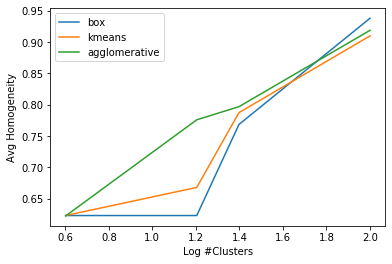

In [78]:
_,ax = plt.subplots()
for graph in graphs:
    graph = np.array(graph)
    ax.plot(np.log10(graph[:,0]), graph[:,1])
    #plt.plot()
    ax.set_xlabel('Log #Clusters')
    ax.set_ylabel('Avg Homogeneity')

ax.legend(names)
plt.show()